# **ReadMe:**
Hi mods! So, what I've done is instead of taking a single target I've taken 2 targets(days delayed and days taken to complete the payment) and I took the mean of both the predictions to get more accurate results.


# Importing Libraries

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder

# Reading Database

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/dataset.csv")

# Preliminary Data Checking

In [ ]:
# Check for number of empty values:
data.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    6
isOpen                        0
dtype: int64

In [ ]:
# Checking the data types of the columns:
data.dtypes

business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year             float64
doc_id                    float64
posting_date               object
document_create_date        int64
document_create_date.1      int64
due_in_date               float64
invoice_currency           object
document type              object
posting_id                float64
area_business             float64
total_open_amount         float64
baseline_create_date      float64
cust_payment_terms         object
invoice_id                float64
isOpen                      int64
dtype: object

In [ ]:
# Check for overall shape:
data.shape

(50000, 19)

In [ ]:
print(dict(data['cust_number'].value_counts()))

{'0200769623': 11483, '0200726979': 1885, '0200762301': 1557, '0200759878': 1395, '0200794332': 1142, '0200744019': 1091, '0200772670': 889, '0200705742': 793, '200769623': 785, '0200707822': 690, 'CCU013': 609, '0200418007': 570, '0140104409': 532, 'CCCA02': 492, '0140106408': 485, '0200780383': 479, '0200803720': 450, '0200761734': 429, '0140104429': 415, '0100031704': 408, '0200706844': 407, '0200353024': 389, '0200148860': 387, '0200230690': 372, '0200416837': 357, '0200793568': 351, '0200799367': 346, '0200936373': 340, '0200704858': 326, '0200020431': 316, '0140105686': 307, '0200772595': 305, '0140104440': 298, '0200974851': 275, '0200782001': 238, '0200729942': 236, '0200592182': 219, '0200739534': 217, '0200704045': 210, '0200714710': 205, '0140104423': 186, '0200752302': 181, '0140105847': 181, '0200764795': 180, '0200777735': 174, '0200792734': 172, '0200900909': 172, '0200763814': 161, '0200776463': 159, '0200781803': 152, '0200152991': 146, '0200705372': 145, '200726979': 

# Currency conversion

In [ ]:
data["converted_usd"] = np.where(data["invoice_currency"] == "CAD", data["total_open_amount"]*0.7, data["total_open_amount"])

# Dropping Data by preliminary inspection

> Dropping Useless Columns which have ID's


In [ ]:
# ALL these columns have useless data or are over-unique (Like ID numbers, etc):
del data['area_business']
del data['buisness_year']
del data['business_code']
del data['invoice_currency']
del data['document type']
del data['posting_id']
del data['isOpen']
del data['document_create_date.1']
del data['document_create_date']
del data['baseline_create_date']
del data['doc_id']
data.shape

(50000, 9)

In [ ]:
data = data.drop_duplicates()

# Dealing with data conversion

In [ ]:
# Convert objects/strings to their respective date types and sorting it:
data['posting_date'] = data['posting_date'].astype("str")
data['posting_date'] = pd.to_datetime(data['posting_date'])
data = data.sort_values(by = ['posting_date'])
data.dtypes

cust_number                   object
name_customer                 object
clear_date                    object
posting_date          datetime64[ns]
due_in_date                  float64
total_open_amount            float64
cust_payment_terms            object
invoice_id                   float64
converted_usd                float64
dtype: object

In [ ]:
# Checking the data:
data.head()

,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,cust_payment_terms,invoice_id,converted_usd
36566,0200769623,WAL-MAR corp,2019-01-09 00:00:00,2018-12-30,20190114.0,4106.09,NAH4,1.928534e+09,4106.09
2793,0200769623,WAL-MAR corp,2019-01-10 00:00:00,2018-12-30,20190114.0,1448.77,NAH4,1.928534e+09,1448.77
20939,0200769623,WAL-MAR corporation,2019-01-10 00:00:00,2018-12-30,20190114.0,27793.93,NAH4,1.928544e+09,27793.93
32821,0200769623,WAL-MAR foundation,2019-01-09 00:00:00,2018-12-30,20190114.0,25749.68,NAH4,1.928536e+09,25749.68
11621,0200769623,WAL-MAR us,2019-01-15 00:00:00,2018-12-30,20190114.0,4439.84,NAH4,1.928541e+09,4439.84


In [ ]:
# Custom string formats detected, lets convert these to date formats too:
data.due_in_date = data.due_in_date.astype("int64")
data.due_in_date = data.due_in_date.astype("str")
data.due_in_date = pd.to_datetime(data['due_in_date'],format = "%Y%m%d")
data.head(2)

,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,cust_payment_terms,invoice_id,converted_usd
36566,0200769623,WAL-MAR corp,2019-01-09 00:00:00,2018-12-30,2019-01-14,4106.09,NAH4,1.928534e+09,4106.09
2793,0200769623,WAL-MAR corp,2019-01-10 00:00:00,2018-12-30,2019-01-14,1448.77,NAH4,1.928534e+09,1448.77


# Encoding Alphanumeric Data using a LabelEncoder

In [ ]:
# Found alphanumeric column 'cust_payment_terms', time to make it numeric only:
terms_enc = LabelEncoder()
data['terms_encoded'] = terms_enc.fit_transform(data['cust_payment_terms'])
del data['cust_payment_terms']
data.head(1)

,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,invoice_id,converted_usd,terms_encoded
36566,0200769623,WAL-MAR corp,2019-01-09 00:00:00,2018-12-30,2019-01-14,4106.09,1.928534e+09,4106.09,39


# Splitting

Data gets split into:
> Training Data


> Actual empty values(that we have to predict)

In [ ]:
# Split by cheching if clear_date is empty or not:
data_train = data[data.clear_date.isnull() == False] 
data_test = data[data.clear_date.isnull()]
data_train.shape,data_test.shape

((39158, 9), (9681, 9))

In [ ]:
# Check the data that we split:
data_train.info(),data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39158 entries, 36566 to 2874
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        39158 non-null  object        
 1   name_customer      39158 non-null  object        
 2   clear_date         39158 non-null  object        
 3   posting_date       39158 non-null  datetime64[ns]
 4   due_in_date        39158 non-null  datetime64[ns]
 5   total_open_amount  39158 non-null  float64       
 6   invoice_id         39152 non-null  float64       
 7   converted_usd      39158 non-null  float64       
 8   terms_encoded      39158 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 17205 to 4120
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------

(None, None)

In [ ]:
data_train.head(1)

,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,invoice_id,converted_usd,terms_encoded
36566,0200769623,WAL-MAR corp,2019-01-09 00:00:00,2018-12-30,2019-01-14,4106.09,1.928534e+09,4106.09,39


In [ ]:
# More date conversions on only the train part:
data_train.clear_date = data_train.clear_date.astype("str")
data_train.clear_date = pd.to_datetime(data_train.clear_date,format = "%Y-%m-%d")
data_train

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,invoice_id,converted_usd,terms_encoded
36566,0200769623,WAL-MAR corp,2019-01-09,2018-12-30,2019-01-14,4106.09,1.928534e+09,4106.09,39
2793,0200769623,WAL-MAR corp,2019-01-10,2018-12-30,2019-01-14,1448.77,1.928534e+09,1448.77,39
20939,0200769623,WAL-MAR corporation,2019-01-10,2018-12-30,2019-01-14,27793.93,1.928544e+09,27793.93,39
32821,0200769623,WAL-MAR foundation,2019-01-09,2018-12-30,2019-01-14,25749.68,1.928536e+09,25749.68,39
11621,0200769623,WAL-MAR us,2019-01-15,2018-12-30,2019-01-14,4439.84,1.928541e+09,4439.84,39
...,...,...,...,...,...,...,...,...,...
32368,0200759878,SA corp,2020-03-05,2020-02-26,2020-05-01,5319.00,1.930569e+09,5319.00,38
27674,0200712105,WALG trust,2020-03-12,2020-02-26,2020-03-12,35584.94,1.930574e+09,35584.94,22
16955,0200759878,SA corp,2020-03-13,2020-02-27,2020-03-13,49290.19,1.930574e+09,49290.19,39
19322,0200739044,PERFOR corporation,2020-03-16,2020-02-27,2020-03-13,25143.02,1.930574e+09,25143.02,22


# Feature Engineering and EDA

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 17205 to 4120
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        9681 non-null   object        
 1   name_customer      9681 non-null   object        
 2   clear_date         0 non-null      object        
 3   posting_date       9681 non-null   datetime64[ns]
 4   due_in_date        9681 non-null   datetime64[ns]
 5   total_open_amount  9681 non-null   float64       
 6   invoice_id         9681 non-null   float64       
 7   converted_usd      9681 non-null   float64       
 8   terms_encoded      9681 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 756.3+ KB


In [ ]:
#Empty column in real world test set
del data_test['clear_date']

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 17205 to 4120
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        9681 non-null   object        
 1   name_customer      9681 non-null   object        
 2   posting_date       9681 non-null   datetime64[ns]
 3   due_in_date        9681 non-null   datetime64[ns]
 4   total_open_amount  9681 non-null   float64       
 5   invoice_id         9681 non-null   float64       
 6   converted_usd      9681 non-null   float64       
 7   terms_encoded      9681 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 680.7+ KB


In [ ]:
# Creating time deltas of dates in the data and then converting them to integers:
data_train['days_delayed'] = (data_train['clear_date'] - data_train['due_in_date']).dt.days.astype('int64')
data_train['days_taken'] = (data_train['clear_date'] - data_train['posting_date']).dt.days.astype('int64')
data_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cust_number,name_customer,clear_date,posting_date,due_in_date,total_open_amount,invoice_id,converted_usd,terms_encoded,days_delayed,days_taken
36566,0200769623,WAL-MAR corp,2019-01-09,2018-12-30,2019-01-14,4106.09,1.928534e+09,4106.09,39,-5,10
2793,0200769623,WAL-MAR corp,2019-01-10,2018-12-30,2019-01-14,1448.77,1.928534e+09,1448.77,39,-4,11
20939,0200769623,WAL-MAR corporation,2019-01-10,2018-12-30,2019-01-14,27793.93,1.928544e+09,27793.93,39,-4,11
32821,0200769623,WAL-MAR foundation,2019-01-09,2018-12-30,2019-01-14,25749.68,1.928536e+09,25749.68,39,-5,10
11621,0200769623,WAL-MAR us,2019-01-15,2018-12-30,2019-01-14,4439.84,1.928541e+09,4439.84,39,1,16
...,...,...,...,...,...,...,...,...,...,...,...
32368,0200759878,SA corp,2020-03-05,2020-02-26,2020-05-01,5319.00,1.930569e+09,5319.00,38,-57,8
27674,0200712105,WALG trust,2020-03-12,2020-02-26,2020-03-12,35584.94,1.930574e+09,35584.94,22,0,15
16955,0200759878,SA corp,2020-03-13,2020-02-27,2020-03-13,49290.19,1.930574e+09,49290.19,39,0,15
19322,0200739044,PERFOR corporation,2020-03-16,2020-02-27,2020-03-13,25143.02,1.930574e+09,25143.02,22,3,18


In [ ]:
# Quick dtype check:
data_train.dtypes

cust_number                  object
name_customer                object
clear_date           datetime64[ns]
posting_date         datetime64[ns]
due_in_date          datetime64[ns]
total_open_amount           float64
invoice_id                  float64
converted_usd               float64
terms_encoded                 int64
days_delayed                  int64
days_taken                    int64
dtype: object

In [ ]:
# Now these dates are useless in Training set:
del data_train['clear_date']
del data_train['posting_date']
del data_train['due_in_date']
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39158 entries, 36566 to 2874
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_number        39158 non-null  object 
 1   name_customer      39158 non-null  object 
 2   total_open_amount  39158 non-null  float64
 3   invoice_id         39152 non-null  float64
 4   converted_usd      39158 non-null  float64
 5   terms_encoded      39158 non-null  int64  
 6   days_delayed       39158 non-null  int64  
 7   days_taken         39158 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.7+ MB


In [ ]:
data_train.head(1)

,cust_number,name_customer,total_open_amount,invoice_id,converted_usd,terms_encoded,days_delayed,days_taken
36566,0200769623,WAL-MAR corp,4106.09,1.928534e+09,4106.09,39,-5,10


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 17205 to 4120
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        9681 non-null   object        
 1   name_customer      9681 non-null   object        
 2   posting_date       9681 non-null   datetime64[ns]
 3   due_in_date        9681 non-null   datetime64[ns]
 4   total_open_amount  9681 non-null   float64       
 5   invoice_id         9681 non-null   float64       
 6   converted_usd      9681 non-null   float64       
 7   terms_encoded      9681 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 680.7+ KB


# Dealing with Outliers

32058.09042545603 17245.895 0    1897.5
dtype: float64


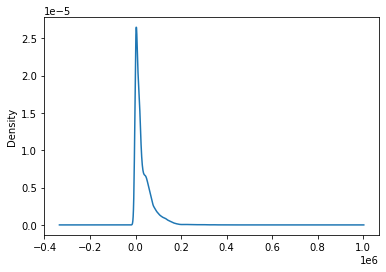

In [ ]:
# Lets do a quick distribution plt for our data:
data_train.total_open_amount.plot.kde()
print(data_train.total_open_amount.mean(),data_train.total_open_amount.median(),data_train.total_open_amount.mode())

In [ ]:
# Outliers exist, time to delete them according to their existance in the percentile range:
def find_new_boundaries(df,column,iq):
  q25, q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
  iqr = q75 - q25
  cut_off = iqr * iq
  return q25 - cut_off, q75 + cut_off

In [ ]:
# Applying above function to the data itself: 
iq = 1.5
low, high = find_new_boundaries(data_train,"total_open_amount",iq)
data_train = data_train[data_train['total_open_amount'].between(low,high,inclusive = True)]
low, high = find_new_boundaries(data_train,"days_delayed",iq)
data_train = data_train[data_train['days_delayed'].between(low,high,inclusive = True)]
low, high = find_new_boundaries(data_train,"days_taken",iq)
data_train = data_train[data_train['days_taken'].between(low,high,inclusive = True)]
data_train.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


(31405, 8)

# Splitting training sets into 2 different sets based on the data I want to predict

In [ ]:
data_train_delayed = data_train[['total_open_amount','terms_encoded','days_delayed']]
data_train_totaldays = data_train[['total_open_amount','terms_encoded','days_taken']]
data_train_delayed.info(),data_train_totaldays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31405 entries, 36566 to 2874
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_open_amount  31405 non-null  float64
 1   terms_encoded      31405 non-null  int64  
 2   days_delayed       31405 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 981.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31405 entries, 36566 to 2874
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_open_amount  31405 non-null  float64
 1   terms_encoded      31405 non-null  int64  
 2   days_taken         31405 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 981.4 KB


(None, None)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31405 entries, 36566 to 2874
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_number        31405 non-null  object 
 1   name_customer      31405 non-null  object 
 2   total_open_amount  31405 non-null  float64
 3   invoice_id         31405 non-null  float64
 4   converted_usd      31405 non-null  float64
 5   terms_encoded      31405 non-null  int64  
 6   days_delayed       31405 non-null  int64  
 7   days_taken         31405 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.2+ MB


# Output 1 :
Here we predict based on the number of days that the customer will delay.

Train Val Test Split:

In [ ]:
# Train Validation Test split is done in this and the next cell:
X_delayed = data_train_delayed.drop('days_delayed',axis=1)
y_delayed = data_train_delayed['days_delayed']

X_delayed_train,X_delayed_inner_test,y_delayed_train,y_delayed_inner_test = train_test_split(X_delayed,
                                                                                             y_delayed,
                                                                                             test_size =.3,
                                                                                             random_state = 0,
                                                                                             shuffle = False)


In [ ]:
X_delayed_val, X_delayed_test, y_delayed_val, y_delayed_test = train_test_split(X_delayed_inner_test,
                                                                                y_delayed_inner_test,
                                                                                test_size = .5,
                                                                                random_state = 0,
                                                                                shuffle = 0)

In [ ]:
# Checking the shapes:
X_delayed_train.shape,X_delayed_val.shape,X_delayed_test.shape

((21983, 2), (4711, 2), (4711, 2))

In [ ]:
y_delayed_train.shape,y_delayed_test.shape,y_delayed_val.shape

((21983,), (4711,), (4711,))

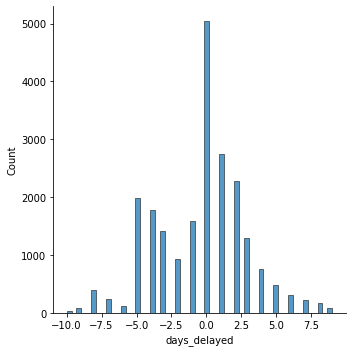

In [ ]:
# Lets do a graph too:
sns.displot(y_delayed_train)

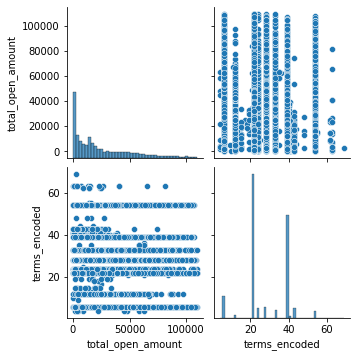

In [ ]:
# Pairplot and info of training data: 
sns.pairplot(X_delayed_train)

In [ ]:
X_delayed_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21983 entries, 36566 to 3349
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_open_amount  21983 non-null  float64
 1   terms_encoded      21983 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.0 MB


Trying different models and comparing the MSE of the validation set.

In [ ]:
#Model 1 : Linear Regressor
LRmodel = LinearRegression()
LRmodel.fit(X_delayed_train,y_delayed_train)
LR_pred = LRmodel.predict(X_delayed_val)
mean_squared_error(y_delayed_val,LR_pred,squared = False)

2.8619284261823896

In [ ]:
#Model 2: Default Decision Tree Regressor:
DTRmodel_default = DecisionTreeRegressor()
DTRmodel_default.fit(X_delayed_train,y_delayed_train)
DTR_default_pred = DTRmodel_default.predict(X_delayed_val)
mean_squared_error(y_delayed_val,DTR_default_pred,squared = False)

3.4553503480653256

In [ ]:
#Model 3: Decission Tree Regressor with Randomsearch to find best params:
DTRmodel = DecisionTreeRegressor()
param_dist = {
              "max_depth": [2,3,4,5,6,10,None],
              "max_features": [0,1,2,3,4,5,6,10],
              "min_samples_leaf": randint(1,9),
              "criterion": ["mse"]
              }
gridDTR = RandomizedSearchCV(DTRmodel,param_dist,
                            n_iter = 20, cv = 3, verbose=2, random_state=42,
                            n_jobs=-1)
gridDTR.fit(X_delayed_train,y_delayed_train)
DTR_best_pred = gridDTR.best_estimator_.predict(X_delayed_val)
mean_squared_error(y_delayed_val,DTR_best_pred,squared = False)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
39 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, 

2.550734268538492

In [ ]:
#Model 4: Default Random Forest Regression(RFR):
RFmodel_default = RandomForestRegressor(random_state=1)
RFmodel_default.fit(X_delayed_train,y_delayed_train)
RF_default_pred = RFmodel_default.predict(X_delayed_val)
mean_squared_error(y_delayed_val,RF_default_pred,squared = False)

2.9788769985053536

In [ ]:
#Model 5: RFR with RandomsearchCV:
RFmodel = RandomForestRegressor(random_state=1)
n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
max_depth.append(None)
bootstrap = [True, False]
r_grid = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'bootstrap': bootstrap
          }
gridRF = RandomizedSearchCV(estimator=RFmodel, param_distributions=r_grid,
                            n_iter = 20, cv = 3, verbose=2, random_state=42,
                            n_jobs=-1)
gridRF.fit(X_delayed_train,y_delayed_train)
RF_best_pred = gridRF.best_estimator_.predict(X_delayed_val)
mean_squared_error(y_delayed_val,RF_best_pred,squared = False)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2.5348594078267044

In [ ]:
#Model 6: RFR custom:
# RFR with least error in a random test that I made:
RFmodel_custom = RandomForestRegressor(max_depth=7,max_leaf_nodes=20,min_samples_leaf=5)
RFmodel_custom.fit(X_delayed_train,y_delayed_train)
RF_train_pred = RFmodel_custom.predict(X_delayed_val)
mean_squared_error(y_delayed_val,RF_train_pred,squared=False)
#2.6169419606948114

2.535373903129006

In [ ]:
#Model 7: XGBoost Regressor:
XGB_RFModel = XGBRegressor(n_estimators=2000,max_depth=2,eta=0.1,subsample=0.7,colsample_bytree=0.1)
XGB_RFModel.fit(X_delayed_train,y_delayed_train)
XGB_RFModel_pred = XGB_RFModel.predict(X_delayed_val)
mean_squared_error(y_delayed_val,XGB_RFModel_pred,squared=False)

[15:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2.5272369974964226

In [ ]:
#Model 8: XGBoost RFRegressor
XGB_RFRModel = XGBRFRegressor(n_estimators=2000,max_depth=2,eta=0.1,subsample=0.7,colsample_bytree=0.1)
XGB_RFRModel.fit(X_delayed_train,y_delayed_train)
XGB_RFRModel_pred = XGB_RFRModel.predict(X_delayed_val)
mean_squared_error(y_delayed_val,XGB_RFRModel_pred,squared=False)

[15:40:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2.9004680558056775

In [ ]:
X_delayed_train['total_open_amount'] = X_delayed_train['total_open_amount'].astype(int)

In [ ]:
X_delayed_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21983 entries, 36566 to 3349
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   total_open_amount  21983 non-null  int64
 1   terms_encoded      21983 non-null  int64
dtypes: int64(2)
memory usage: 1.0 MB


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=5)
knn.fit(X_delayed_train,y_delayed_train)

KNeighborsClassifier()

In [ ]:
X_delayed_val['total_open_amount'] = X_delayed_val['total_open_amount'].astype(int)

In [ ]:
X_delayed_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4711 entries, 23811 to 37936
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   total_open_amount  4711 non-null   int64
 1   terms_encoded      4711 non-null   int64
dtypes: int64(2)
memory usage: 110.4 KB


In [ ]:
y_delayed_test=y_delayed_test.to_frame()

In [ ]:
y_pred=knn.predict(X_delayed_val)

In [ ]:
y_pred=pd.DataFrame(y_pred, columns=['a'])

In [ ]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   a       4711 non-null   int64
dtypes: int64(1)
memory usage: 36.9 KB


In [ ]:
y_delayed_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4711 entries, 21573 to 32302
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   days_delayed  4711 non-null   int64
dtypes: int64(1)
memory usage: 73.6 KB


Applying the trained data to test set and comparing MSE of test set to chose the best model


In [ ]:
#Using the Test Data we made in train_test_split:

#Linear Regression Model:
LR_test_pred = LRmodel.predict(X_delayed_test)
#Decission Tree Regressor with default values:
DTR_default_test_pred = DTRmodel_default.predict(X_delayed_test)
#Decission Tree Regressor with randomisedsearchCV
DTR_best_test_pred = gridDTR.best_estimator_.predict(X_delayed_test)
#Random Forest Regressor with default values
RF_default_test_pred = RFmodel_default.predict(X_delayed_test)
#RFR with randomisedsearchCV
RF_best_test_pred = gridRF.best_estimator_.predict(X_delayed_test)
#RFR with custom values
RF_custom_test_pred = RFmodel_custom.predict(X_delayed_test)
#XGBReg
XGB_RFModel_test_pred = XGB_RFModel.predict(X_delayed_test)
#XGBRFReg
XGB_RFRModel_test_pred = XGB_RFRModel.predict(X_delayed_test)

print(
    "LR basic: "    + str(mean_squared_error(y_delayed_test,LR_test_pred,squared = False)) + "\n" +
    "DTR default: " + str(mean_squared_error(y_delayed_test,DTR_default_test_pred,squared = False)) + "\n" +
    "DTR best: "    + str(mean_squared_error(y_delayed_test,DTR_best_test_pred,squared = False)) + "\n" +
    "RFR default: " + str(mean_squared_error(y_delayed_test,RF_default_test_pred,squared = False)) + "\n" +
    "RFR best: "    + str(mean_squared_error(y_delayed_test,RF_best_test_pred,squared = False)) + "\n" +
    "RFR custom: "  + str(mean_squared_error(y_delayed_test,RF_custom_test_pred,squared = False)) + "\n" +
    "XGB Reg: "  + str(mean_squared_error(y_delayed_test,XGB_RFModel_test_pred,squared = False)) + "\n" +
    "XGB RFReg: "  + str(mean_squared_error(y_delayed_test,XGB_RFRModel_test_pred,squared = False)) + "\n"
)

LR basic: 2.730801856740771
DTR default: 3.445328979290197
DTR best: 2.464242542223585
RFR default: 2.9333184627416493
RFR best: 2.446287113590692
RFR custom: 2.4462510791678893
XGB Reg: 2.4551015994298253
XGB RFReg: 2.7969283913639424



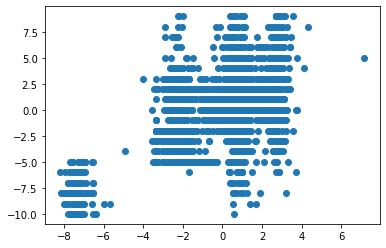

In [ ]:
plt.scatter(XGB_RFModel_test_pred,y_delayed_test)

Best Performer with data_delayed: RFR Custom

# Output 2:

Here we predict based on the number of days the customer takes to pay.

Train Val Test split

In [ ]:
# Using Total days taken as Y
X_totaldays = data_train_totaldays.drop('days_taken',axis=1)
y_totaldays = data_train_totaldays['days_taken']

X_totaldays_train,X_totaldays_inner_test,y_totaldays_train,y_totaldays_inner_test = train_test_split(X_totaldays,y_totaldays,test_size =.3,random_state = 0,shuffle = False)

In [ ]:
X_totaldays_val, X_totaldays_test, y_totaldays_val, y_totaldays_test = train_test_split(X_totaldays_inner_test,
                                                                                y_totaldays_inner_test,
                                                                                test_size = .5,
                                                                                random_state = 0,
                                                                                shuffle = 0)

In [ ]:
X_totaldays_train.shape,X_totaldays_val.shape,X_totaldays_test.shape

((21983, 2), (4711, 2), (4711, 2))

In [ ]:
y_totaldays_train.shape,y_totaldays_test.shape,y_totaldays_val.shape

((21983,), (4711,), (4711,))

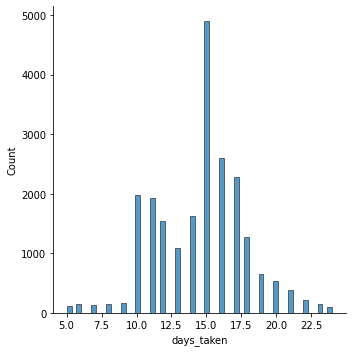

In [ ]:
sns.displot(y_totaldays_train)

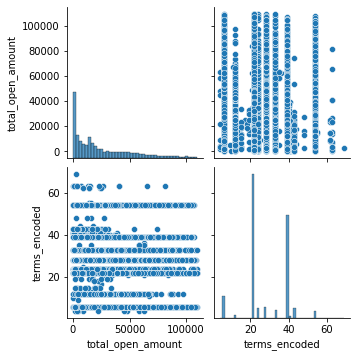

In [ ]:
sns.pairplot(X_totaldays_train)

In [ ]:
X_totaldays_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21983 entries, 36566 to 3349
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_open_amount  21983 non-null  float64
 1   terms_encoded      21983 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.0 MB


Applying different models to test MSE score of validation set.

In [ ]:
#Linear Regressor
LRmodel_totaldays = LinearRegression()
LRmodel_totaldays.fit(X_totaldays_train,y_totaldays_train)
LR_pred_totaldays = LRmodel_totaldays.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,LR_pred_totaldays,squared = False)

3.0186472341692343

In [ ]:
#Decision Tree Regressor:
DTRmodel_default_totaldays = DecisionTreeRegressor()
DTRmodel_default_totaldays.fit(X_totaldays_train,y_totaldays_train)
DTR_default_pred_totaldays = DTRmodel_default_totaldays.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,DTR_default_pred_totaldays,squared = False)

3.5041778548015134

In [ ]:
#DTR with Randomsearch:
DTRmodel_totaldays = DecisionTreeRegressor()
param_dist_totaldays = {
              "max_depth": [2,3,4,5,6,10,None],
              "max_features": [0,1,2,3,4,5,6,10],
              "min_samples_leaf": randint(1,9),
              "criterion": ["mse"]
              }
gridDTR_totaldays = RandomizedSearchCV(DTRmodel_totaldays,param_dist_totaldays,
                            n_iter = 20, cv = 3, verbose=2, random_state=42,
                            n_jobs=-1)
gridDTR_totaldays.fit(X_totaldays_train,y_totaldays_train)
DTR_best_pred_totaldays = gridDTR_totaldays.best_estimator_.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,DTR_best_pred_totaldays,squared = False)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
39 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, 

2.6066137270400773

In [ ]:
#Default Random Forest Regression:
RFmodel_default_totaldays = RandomForestRegressor(random_state=1)
RFmodel_default_totaldays.fit(X_totaldays_train,y_totaldays_train)
RF_default_pred_totaldays = RFmodel_default_totaldays.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,RF_default_pred_totaldays,squared = False)

3.017872543840595

In [ ]:
#RFR with RandomsearchCV:
RFmodel_totaldays = RandomForestRegressor(random_state=1)
n_estimators_totaldays = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)]
max_features_totaldays = ['auto', 'log2']
max_depth_totaldays = [int(x) for x in np.linspace(5, 10, num = 2)] 
max_depth_totaldays.append(None)
bootstrap_totaldays = [True, False]
r_grid_totaldays = {'n_estimators': n_estimators_totaldays,
          'max_features': max_features_totaldays,
          'max_depth': max_depth_totaldays,
          'bootstrap': bootstrap_totaldays
          }
gridRF_totaldays = RandomizedSearchCV(estimator=RFmodel_totaldays, param_distributions=r_grid_totaldays,
                                      n_iter = 20, cv = 3, verbose=2, random_state=42,
                                      n_jobs=-1)
gridRF_totaldays.fit(X_totaldays_train,y_totaldays_train)
RF_best_pred_totaldays = gridRF_totaldays.best_estimator_.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,RF_best_pred_totaldays,squared = False)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2.5720293262251244

In [ ]:
#RFR custom:
RFmodel_custom_totaldays = RandomForestRegressor(max_depth=6,max_leaf_nodes=20,min_samples_leaf=5)
RFmodel_custom_totaldays.fit(X_totaldays_train,y_totaldays_train)
RF_train_pred_totaldays = RFmodel_custom_totaldays.predict(X_totaldays_val)
mean_squared_error(y_totaldays_val,RF_train_pred_totaldays,squared=False)

2.5703082893526683

Testing the models using the test set and checking MSE score again.

In [ ]:
#Linear Regression Model:
LR_test_pred_totaldays = LRmodel_totaldays.predict(X_totaldays_test)
#Decission Tree Regressor with default values:
DTR_default_test_pred_totaldays = DTRmodel_default_totaldays.predict(X_totaldays_test)
#DTR with randomisedsearchCV
DTR_best_test_pred_totaldays = gridDTR_totaldays.best_estimator_.predict(X_totaldays_test)
#Random Forest Regressor with default values
RF_default_test_pred_totaldays = RFmodel_default_totaldays.predict(X_totaldays_test)
#RFR with randomisedsearchCV
RF_best_test_pred_totaldays = gridRF_totaldays.best_estimator_.predict(X_totaldays_test)
#RFR with custom values
RF_custom_test_pred_totaldays = RFmodel_custom_totaldays.predict(X_totaldays_test)

print(
    "LR basic: "    + str(mean_squared_error(y_totaldays_test,LR_test_pred_totaldays,squared = False)) + "\n" +
    "DTR default: " + str(mean_squared_error(y_totaldays_test,DTR_default_test_pred_totaldays,squared = False)) + "\n" +
    "DTR best: "    + str(mean_squared_error(y_totaldays_test,DTR_best_test_pred_totaldays,squared = False)) + "\n" +
    "RFR default: " + str(mean_squared_error(y_totaldays_test,RF_default_test_pred_totaldays,squared = False)) + "\n" +
    "RFR best: "    + str(mean_squared_error(y_totaldays_test,RF_best_test_pred_totaldays,squared = False)) + "\n" +
    "RFR custom: "  + str(mean_squared_error(y_totaldays_test,RF_custom_test_pred_totaldays,squared = False))
)

LR basic: 2.943903190199719
DTR default: 3.5271973910358065
DTR best: 2.5495378713854295
RFR default: 3.018410203073497
RFR best: 2.522489438751391
RFR custom: 2.5214979534194093


Again, Custom Random Forest has the best MSE value.

# Final merging

Now we will merge the results of the models to the values we need to predict.

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 17205 to 4120
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        9681 non-null   object        
 1   name_customer      9681 non-null   object        
 2   posting_date       9681 non-null   datetime64[ns]
 3   due_in_date        9681 non-null   datetime64[ns]
 4   total_open_amount  9681 non-null   float64       
 5   invoice_id         9681 non-null   float64       
 6   converted_usd      9681 non-null   float64       
 7   terms_encoded      9681 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 680.7+ KB


Find the values predicted by both models:

In [ ]:
data_test.head()

,cust_number,name_customer,posting_date,due_in_date,total_open_amount,invoice_id,converted_usd,terms_encoded
17205,0200769623,WAL-MAR us,2020-02-27,2020-03-13,8766.38,1.930574e+09,8766.38,39
44483,0200342745,NAPPIE co,2020-02-27,2020-03-13,29033.82,1.930577e+09,29033.82,22
6304,0200769623,WAL-MAR in,2020-02-27,2020-03-13,7473.70,1.930578e+09,7473.70,39
19211,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,54165.47,1.930566e+09,54165.47,39
32204,0200762301,C&S WH,2020-02-27,2020-03-13,139542.80,1.930580e+09,139542.80,28


In [ ]:
data_test_copy = data_test[['cust_number','name_customer','posting_date','due_in_date','invoice_id','total_open_amount','terms_encoded']].copy()

In [ ]:
data_test_copy.head(3)

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,terms_encoded
17205,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,39
44483,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,22
6304,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,39


In [ ]:
data_test = data_test_copy.copy()

In [ ]:
data_test.iloc[:,[-2,-1]].head(2)

,total_open_amount,terms_encoded
17205,8766.38,39
44483,29033.82,22


In [ ]:
# Create pandas series of the predicted values by their respective models:
final_results_delayed = RFmodel_custom.predict(data_test.iloc[:,[-2,-1]])
days_delayed = pd.Series(final_results_delayed,name = "Days_Delayed")

final_results_totaldays = RFmodel_custom_totaldays.predict(data_test.iloc[:,[-2,-1]])
total_days = pd.Series(final_results_totaldays,name = "Total Days Taken")

Creating a copy of the real world data set:

In [ ]:
# Create a copy and drop index
data_test.reset_index(drop=True,inplace = True)
Final = data_test.copy()
Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9681 entries, 0 to 9680
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cust_number        9681 non-null   object        
 1   name_customer      9681 non-null   object        
 2   posting_date       9681 non-null   datetime64[ns]
 3   due_in_date        9681 non-null   datetime64[ns]
 4   invoice_id         9681 non-null   float64       
 5   total_open_amount  9681 non-null   float64       
 6   terms_encoded      9681 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 529.6+ KB


Adding and formatting the values we got to this copy:

In [ ]:
# Add the predicted values into the copied dataframe we made earlier:
Final['Days_Delayed_Predicted'] = days_delayed.astype("int64")
Final['Total_Days_Taken_Predicted'] = total_days.astype("int64")

In [ ]:
Final

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,terms_encoded,Days_Delayed_Predicted,Total_Days_Taken_Predicted
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,39,-1,13
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,22,0,15
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,39,-1,13
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,39,-2,12
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,28,0,15
...,...,...,...,...,...,...,...,...,...
9676,0200763229,MAINES us,2020-05-15,2020-05-30,1.930907e+09,17140.86,22,0,15
9677,0200759878,SA associates,2020-05-17,2020-06-01,1.930897e+09,22835.50,39,-1,13
9678,0200915438,GROC foundation,2020-05-18,2020-06-02,1.930907e+09,1232.00,22,0,15
9679,0100027744,OMEGA AD in,2020-05-19,2020-05-19,2.960636e+09,7035.00,9,2,13


In [ ]:
# Check dtypes:
Final.dtypes

cust_number                           object
name_customer                         object
posting_date                  datetime64[ns]
due_in_date                   datetime64[ns]
invoice_id                           float64
total_open_amount                    float64
terms_encoded                          int64
Days_Delayed_Predicted                 int64
Total_Days_Taken_Predicted             int64
dtype: object

Adding columns to show actual date values of the prediction data:

In [ ]:
# Now to help the humans understand the delay:
Final['Estimated_Date_of_Payment_by_Days_Delayed'] = pd.to_datetime(Final['due_in_date']) + pd.to_timedelta(Final['Days_Delayed_Predicted'],unit='D')
Final['Estimated_Date_of_Payment_by_Total_Days'] = pd.to_datetime(Final['posting_date']) + pd.to_timedelta(Final['Total_Days_Taken_Predicted'],unit='D')
Final

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,terms_encoded,Days_Delayed_Predicted,Total_Days_Taken_Predicted,Estimated_Date_of_Payment_by_Days_Delayed,Estimated_Date_of_Payment_by_Total_Days
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,39,-1,13,2020-03-12,2020-03-11
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,22,0,15,2020-03-13,2020-03-13
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,39,-1,13,2020-03-12,2020-03-11
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,39,-2,12,2020-03-11,2020-03-10
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,28,0,15,2020-03-13,2020-03-13
...,...,...,...,...,...,...,...,...,...,...,...
9676,0200763229,MAINES us,2020-05-15,2020-05-30,1.930907e+09,17140.86,22,0,15,2020-05-30,2020-05-30
9677,0200759878,SA associates,2020-05-17,2020-06-01,1.930897e+09,22835.50,39,-1,13,2020-05-31,2020-05-30
9678,0200915438,GROC foundation,2020-05-18,2020-06-02,1.930907e+09,1232.00,22,0,15,2020-06-02,2020-06-02
9679,0100027744,OMEGA AD in,2020-05-19,2020-05-19,2.960636e+09,7035.00,9,2,13,2020-05-21,2020-06-01


In [ ]:
Final['difference']=(Final['Estimated_Date_of_Payment_by_Days_Delayed']-Final['Estimated_Date_of_Payment_by_Total_Days']).dt.days

In [ ]:
Final['Final_Predicted_Date']=(Final['Estimated_Date_of_Payment_by_Days_Delayed']-(pd.to_timedelta(Final['difference'],unit='D')/2))

In [ ]:
Final.head()

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,terms_encoded,Days_Delayed_Predicted,Total_Days_Taken_Predicted,Estimated_Date_of_Payment_by_Days_Delayed,Estimated_Date_of_Payment_by_Total_Days,difference,Final_Predicted_Date
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,39,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,22,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,39,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,39,-2,12,2020-03-11,2020-03-10,1,2020-03-10 12:00:00
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,28,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00


In [ ]:
Final['Predicted_Clear_Date'] = pd.to_datetime(Final['Final_Predicted_Date']).dt.date

In [ ]:
Final.head()

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,terms_encoded,Days_Delayed_Predicted,Total_Days_Taken_Predicted,Estimated_Date_of_Payment_by_Days_Delayed,Estimated_Date_of_Payment_by_Total_Days,difference,Final_Predicted_Date,Predicted_Clear_Date
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,39,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,22,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,39,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,39,-2,12,2020-03-11,2020-03-10,1,2020-03-10 12:00:00,2020-03-10
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,28,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13


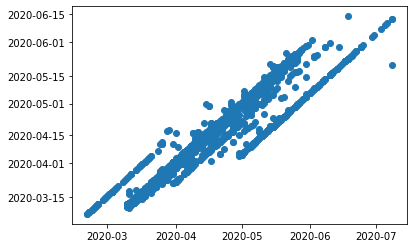

In [ ]:
plt.scatter(Final['Estimated_Date_of_Payment_by_Days_Delayed'],Final['Final_Predicted_Date'])
#Final.difference.value_counts()

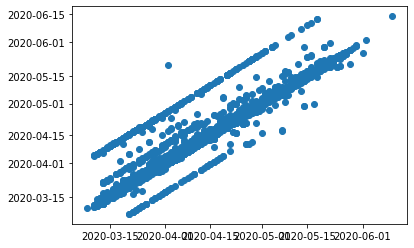

In [ ]:
plt.scatter(Final['Estimated_Date_of_Payment_by_Total_Days'],Final['Final_Predicted_Date'])
#Final.difference.value_counts()

## **Above graphs looks AWESOME!!!!!**

In [ ]:
Final.dtypes

cust_number                                          object
name_customer                                        object
posting_date                                 datetime64[ns]
due_in_date                                  datetime64[ns]
invoice_id                                          float64
total_open_amount                                   float64
terms_encoded                                         int64
Days_Delayed_Predicted                                int64
Total_Days_Taken_Predicted                            int64
Estimated_Date_of_Payment_by_Days_Delayed    datetime64[ns]
Estimated_Date_of_Payment_by_Total_Days      datetime64[ns]
difference                                            int64
Final_Predicted_Date                         datetime64[ns]
Predicted_Clear_Date                                 object
dtype: object

In [ ]:
# Performing inverse transform of the encoded payment terms:
Final['cust_payment_terms'] = terms_enc.inverse_transform(Final['terms_encoded'])
del Final['terms_encoded']

Making it more Friendly to understand:

In [ ]:
# Creating 2 bins for the 2 predicted data that we got, but first, what is the ranges of our data? :
Final['Days_Delayed_Predicted'].value_counts(),Final['Total_Days_Taken_Predicted'].value_counts()

( 0    5061
 -2    1783
 -1    1477
  2     792
 -7     349
 -6     153
  1      43
 -3      21
 -4       2
 Name: Days_Delayed_Predicted, dtype: int64, 15    5611
 12    1907
 13    1293
 23     153
 10     151
 6      141
 19     131
 9      115
 20      55
 16      42
 18      40
 14      30
 17      10
 8        2
 Name: Total_Days_Taken_Predicted, dtype: int64)

In [ ]:
bin_delayed = np.array([-float("inf"),-10,-5,-0,5,10,float("inf")])

Final['Delayed_Bucket'] = pd.cut((Final['difference']/2),bin_delayed)

Final.head(20)

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,Days_Delayed_Predicted,Total_Days_Taken_Predicted,Estimated_Date_of_Payment_by_Days_Delayed,Estimated_Date_of_Payment_by_Total_Days,difference,Final_Predicted_Date,Predicted_Clear_Date,cust_payment_terms,Delayed_Bucket
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11,NAH4,"(0.0, 5.0]"
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAA8,"(-5.0, 0.0]"
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11,NAH4,"(0.0, 5.0]"
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,-2,12,2020-03-11,2020-03-10,1,2020-03-10 12:00:00,2020-03-10,NAH4,"(0.0, 5.0]"
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAC6,"(-5.0, 0.0]"
5,0200750051,ALBER associates,2020-02-27,2020-03-13,1.930580e+09,122172.17,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAA8,"(-5.0, 0.0]"
6,0200769623,WAL-MAR corp,2020-02-27,2020-03-13,1.930570e+09,14947.08,-1,12,2020-03-12,2020-03-10,2,2020-03-11 00:00:00,2020-03-11,NAH4,"(0.0, 5.0]"
7,0200418007,AM corp,2020-02-27,2020-03-13,1.930549e+09,6171.08,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAA8,"(-5.0, 0.0]"
8,0200749225,SUPER associates,2020-02-27,2020-03-13,1.930574e+09,44436.71,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAA8,"(-5.0, 0.0]"
9,0200762301,C&S WH associates,2020-02-27,2020-05-02,1.930575e+09,2356.31,-2,12,2020-04-30,2020-03-10,51,2020-04-04 12:00:00,2020-04-04,NAGD,"(10.0, inf]"


In [ ]:
Final.head()

,cust_number,name_customer,posting_date,due_in_date,invoice_id,total_open_amount,Days_Delayed_Predicted,Total_Days_Taken_Predicted,Estimated_Date_of_Payment_by_Days_Delayed,Estimated_Date_of_Payment_by_Total_Days,difference,Final_Predicted_Date,Predicted_Clear_Date,cust_payment_terms,Delayed_Bucket
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,1.930574e+09,8766.38,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11,NAH4,"(0.0, 5.0]"
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,1.930577e+09,29033.82,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAA8,"(-5.0, 0.0]"
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,1.930578e+09,7473.70,-1,13,2020-03-12,2020-03-11,1,2020-03-11 12:00:00,2020-03-11,NAH4,"(0.0, 5.0]"
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,1.930566e+09,54165.47,-2,12,2020-03-11,2020-03-10,1,2020-03-10 12:00:00,2020-03-10,NAH4,"(0.0, 5.0]"
4,0200762301,C&S WH,2020-02-27,2020-03-13,1.930580e+09,139542.80,0,15,2020-03-13,2020-03-13,0,2020-03-13 00:00:00,2020-03-13,NAC6,"(-5.0, 0.0]"


In [ ]:
Final['total_open_amount_USD']=Final['total_open_amount']

# CSV Export

Final value checking, etc:

In [ ]:
Final['Delayed_Bucket'].value_counts()
# ,Final['Total_Days_Bucket'].value_counts()

(-5.0, 0.0]      5642
(0.0, 5.0]       3512
(10.0, inf]       288
(5.0, 10.0]       145
(-inf, -10.0]      78
(-10.0, -5.0]      16
Name: Delayed_Bucket, dtype: int64

In [ ]:
# Making the ouput even more human friendly:
Final_tosave_copy = Final[[
               'cust_number',
               'name_customer', 
               'posting_date',
               'due_in_date',
               'Predicted_Clear_Date',
               'total_open_amount_USD',
               'cust_payment_terms',
               'Delayed_Bucket']]
Final_tosave_copy.head()

,cust_number,name_customer,posting_date,due_in_date,Predicted_Clear_Date,total_open_amount_USD,cust_payment_terms,Delayed_Bucket
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,2020-03-11,8766.38,NAH4,"(0.0, 5.0]"
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,2020-03-13,29033.82,NAA8,"(-5.0, 0.0]"
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,2020-03-11,7473.70,NAH4,"(0.0, 5.0]"
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,2020-03-10,54165.47,NAH4,"(0.0, 5.0]"
4,0200762301,C&S WH,2020-02-27,2020-03-13,2020-03-13,139542.80,NAC6,"(-5.0, 0.0]"


In [ ]:
Final_tosave_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9681 entries, 0 to 9680
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cust_number            9681 non-null   object        
 1   name_customer          9681 non-null   object        
 2   posting_date           9681 non-null   datetime64[ns]
 3   due_in_date            9681 non-null   datetime64[ns]
 4   Predicted_Clear_Date   9681 non-null   object        
 5   total_open_amount_USD  9681 non-null   float64       
 6   cust_payment_terms     9681 non-null   object        
 7   Delayed_Bucket         9681 non-null   category      
dtypes: category(1), datetime64[ns](2), float64(1), object(4)
memory usage: 539.3+ KB


In [ ]:
Final_tosave_copy['name_customer'] = Final_tosave_copy['name_customer'].astype("str")
Final_tosave_copy['cust_number'] = Final_tosave_copy['cust_number'].astype("str")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Final_tosave_copy.dtypes

cust_number                      object
name_customer                    object
posting_date             datetime64[ns]
due_in_date              datetime64[ns]
Predicted_Clear_Date             object
total_open_amount_USD           float64
cust_payment_terms               object
Delayed_Bucket                 category
dtype: object

In [ ]:
Final_tosave_copy

,cust_number,name_customer,posting_date,due_in_date,Predicted_Clear_Date,total_open_amount_USD,cust_payment_terms,Delayed_Bucket
0,0200769623,WAL-MAR us,2020-02-27,2020-03-13,2020-03-11,8766.38,NAH4,"(0.0, 5.0]"
1,0200342745,NAPPIE co,2020-02-27,2020-03-13,2020-03-13,29033.82,NAA8,"(-5.0, 0.0]"
2,0200769623,WAL-MAR in,2020-02-27,2020-03-13,2020-03-11,7473.70,NAH4,"(0.0, 5.0]"
3,0200769623,WAL-MAR corporation,2020-02-27,2020-03-13,2020-03-10,54165.47,NAH4,"(0.0, 5.0]"
4,0200762301,C&S WH,2020-02-27,2020-03-13,2020-03-13,139542.80,NAC6,"(-5.0, 0.0]"
...,...,...,...,...,...,...,...,...
9676,0200763229,MAINES us,2020-05-15,2020-05-30,2020-05-30,17140.86,NAA8,"(-5.0, 0.0]"
9677,0200759878,SA associates,2020-05-17,2020-06-01,2020-05-30,22835.50,NAH4,"(0.0, 5.0]"
9678,0200915438,GROC foundation,2020-05-18,2020-06-02,2020-06-02,1232.00,NAA8,"(-5.0, 0.0]"
9679,0100027744,OMEGA AD in,2020-05-19,2020-05-19,2020-05-26,7035.00,CAB1,"(-10.0, -5.0]"


In [ ]:
# Final_tosave_copy.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/HRC81268W.csv')

Link to the CSV from this model: https://drive.google.com/file/d/1_y9BM_WQFzJbngsa2iknCB8xmEe-wolH/view?usp=sharing